In [1]:
#import required classes and packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Using TensorFlow backend.
c:\users\91728\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\91728\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\91728\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#define and load class labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())   
print("Chest Disease Class Labels : "+str(labels))

Chest Disease Class Labels : ['Fibrosis', 'InflammationPenumonia', 'Normal', 'Pneumonia']


In [3]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [4]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images
                img = cv2.resize(img, (32, 32))#resize image
                X.append(img) #add image pixels to X array
                label = getLabel(name)#get image label id
                Y.append(label)#add image label                
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

Dataset images loaded
Total images found in dataset : 1572



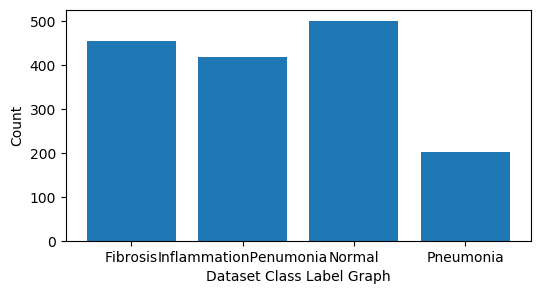

In [5]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (6, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

In [6]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : "+str(X_train.shape[0]))
print("20% image used to train algorithms : "+str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 1257
20% image used to train algorithms : 315


In [7]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [8]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    



CNN Algorithm Accuracy  :  93.33333333333333
CNN Algorithm Precision : 93.90999656940633
CNN Algorithm Recall    : 92.68679986863054
CNN Algorithm FScore    : 93.21044516069674


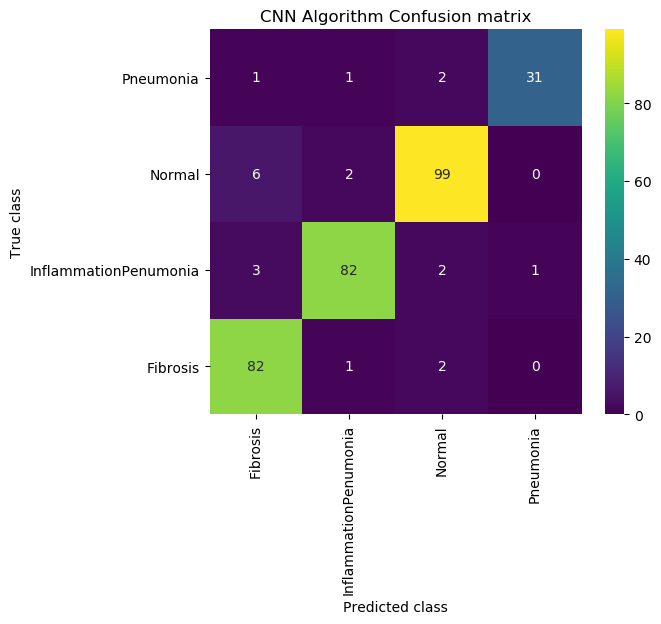

In [9]:
#train CNN algorithm
cnn_model = Sequential()
#defining cnn layer with 3 X 3 matrix to filter dataset using 32 neurons
cnn_model.add(Convolution2D(64, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compiling, training and loading model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train, y_train, batch_size = 64, epochs = 60, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
#perform prediction on test data   
predict = cnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("CNN Algorithm", predict, y_test1)#calculate accuracy and other metrics

Random Forest Algorithm Accuracy  :  41.904761904761905
Random Forest Algorithm Precision : 36.10308037588124
Random Forest Algorithm Recall    : 35.8590955498597
Random Forest Algorithm FScore    : 34.53028481607121


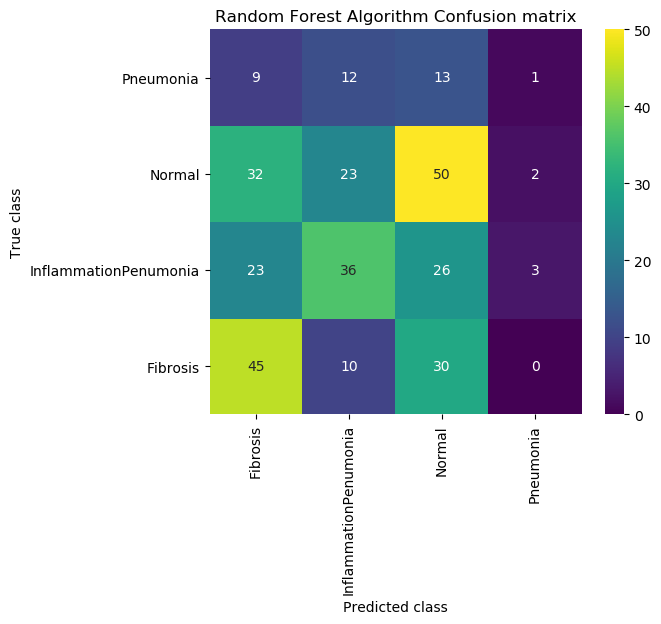

In [10]:
#training Random Forest machine learning algorithm
y_test = np.argmax(y_test, axis=1)
y_train = np.argmax(y_train, axis=1)
X_train = np.reshape(X_train, (X_train.shape[0], (X_train.shape[1] * X_train.shape[2] * X_train.shape[3])))
X_test = np.reshape(X_test, (X_test.shape[0], (X_test.shape[1] * X_test.shape[2] * X_test.shape[3])))
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predict = rf.predict(X_test)
calculateMetrics("Random Forest Algorithm", predict, y_test1)#calculate accuracy and other metrics

Decision Tree Algorithm Accuracy  :  28.57142857142857
Decision Tree Algorithm Precision : 25.345008992879077
Decision Tree Algorithm Recall    : 25.2629843356204
Decision Tree Algorithm FScore    : 25.299834781839557


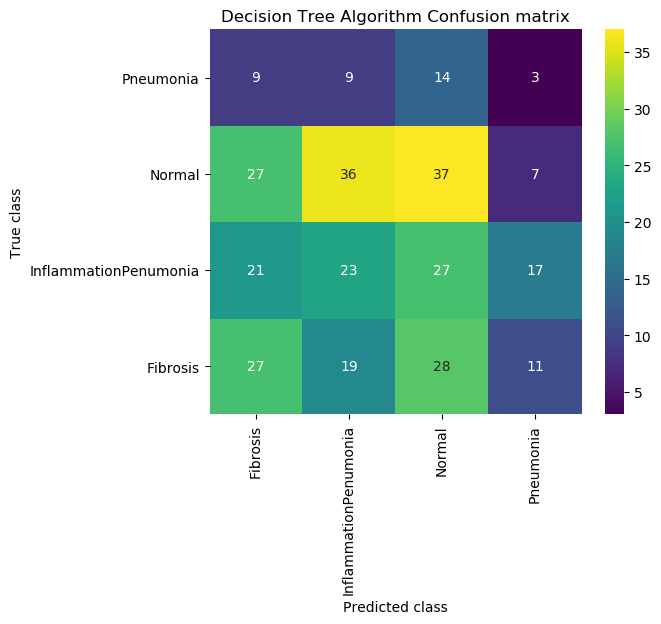

In [11]:
#training decision tree algorithm
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predict = dt.predict(X_test)
calculateMetrics("Decision Tree Algorithm", predict, y_test1)#calculate accuracy and other metrics

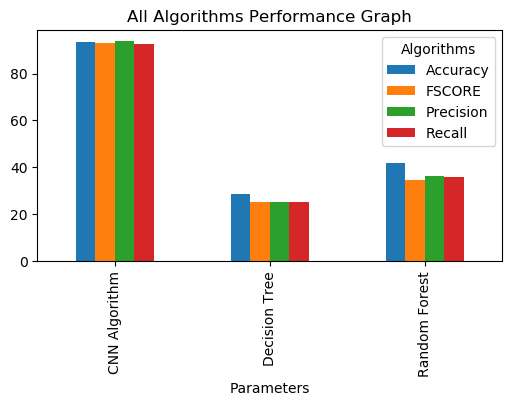

In [12]:
#plot all algorithm performance in tabukar format
import pandas as pd
df = pd.DataFrame([['CNN Algorithm','Accuracy',accuracy[0]],['CNN Algorithm','Precision',precision[0]],['CNN Algorithm','Recall',recall[0]],['CNN Algorithm','FSCORE',fscore[0]],
                   ['Random Forest','Accuracy',accuracy[1]],['Random Forest','Precision',precision[1]],['Random Forest','Recall',recall[1]],['Random Forest','FSCORE',fscore[1]],
                   ['Decision Tree','Accuracy',accuracy[2]],['Decision Tree','Precision',precision[2]],['Decision Tree','Recall',recall[2]],['Decision Tree','FSCORE',fscore[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [13]:
#display all algorithm performnace
algorithms = ['CNN Algorithm', 'Random Forest', 'Decision Tree']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data  

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,CNN Algorithm,93.333333,93.909997,92.686800,93.210445
1,Random Forest,41.904762,36.103080,35.859096,34.530285
2,Decision Tree,28.571429,25.345009,25.262984,25.299835


In [14]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (28, 28))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,28,28,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    predict = cnn_model.predict(img)#now predict dog breed
    predict = np.argmax(predict)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (500,300))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Chest Disease : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.imshow(img)

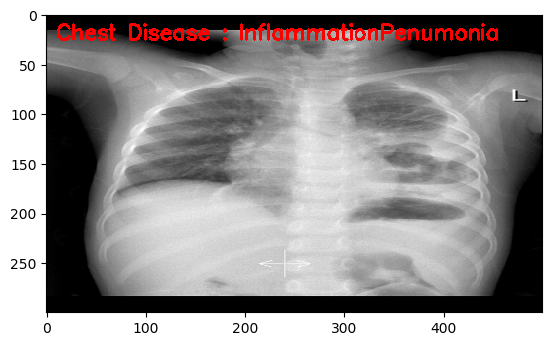

In [15]:
#call this function with test image to predict dog breed
predict("testImages/cavitating Pneumonia.jpeg")

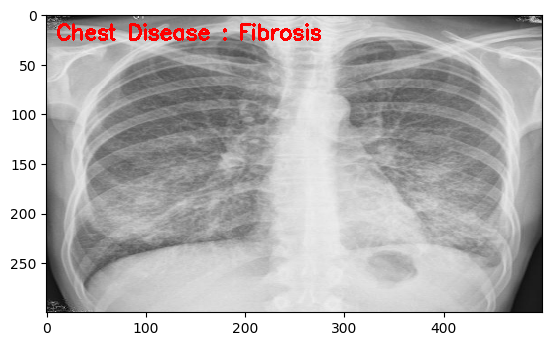

In [16]:
#call this function with test image to predict dog breed
predict("testImages/WhatsApp Image 2024-06-28 at 3.46.38 PM (1).jpeg")

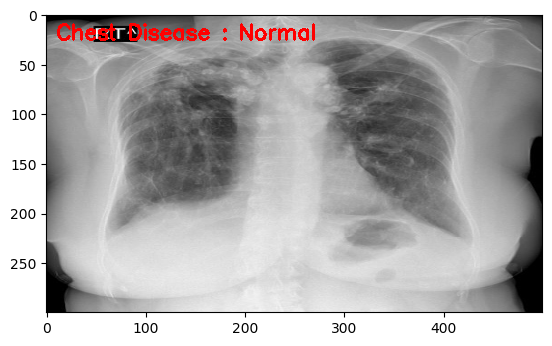

In [17]:
#call this function with test image to predict dog breed
predict("testImages/WhatsApp Image 2024-06-28 at 3.47.09 PM.jpeg")

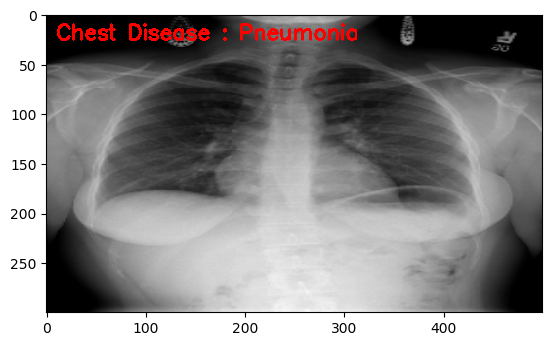

In [18]:
#call this function with test image to predict dog breed
predict("testImages/3.png")